In [4]:
# notebook providing a minimum example for what is described in:



In [10]:
import numpy as np
from scipy import ndimage
import pylab as plt
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.align import VerbosityLevels
import dipy

def get_custom_scalespace_init(scaling_factors):

    """
    provides custom dipy.align.imwarp.ScaleSpace.__init__ constructor
    incorporating user defined scaling_factors
    which are set for every resolution level
    """

    # invert order of scaling_factors
    # input to this function: order of registration
    # needed for init: opposite (ascending) order
    
    scaling_factors = scaling_factors[::-1]
    
    def custom_init(ss, image, num_levels,
                 image_grid2world=None,
                 input_spacing=None,
                 sigma_factor=0.2,
                 mask0=False):

        from numpy import float64 as floating
        from numpy import linalg as npl
        from scipy.ndimage import filters as filters
        
        r""" ScaleSpace
        Computes the Scale Space representation of an image. The scale space is
        simply a list of images produced by smoothing the input image with a
        Gaussian kernel with increasing smoothing parameter. If the image's
        voxels are isotropic, the smoothing will be the same along all
        directions: at level L = 0, 1, ..., the sigma is given by
        $s * ( 2^L - 1 )$.
        If the voxel dimensions are not isotropic, then the smoothing is
        weaker along low resolution directions.
        Parameters
        ----------
        image : array, shape (r,c) or (s, r, c) where s is the number of
            slices, r is the number of rows and c is the number of columns of
            the input image.
        num_levels : int
            the desired number of levels (resolutions) of the scale space
        image_grid2world : array, shape (dim + 1, dim + 1), optional
            the grid-to-space transform of the image grid. The default is
            the identity matrix
        input_spacing : array, shape (dim,), optional
            the spacing (voxel size) between voxels in physical space. The
            default is 1.0 along all axes
        sigma_factor : float, optional
            the smoothing factor to be used in the construction of the scale
            space. The default is 0.2
        mask0 : Boolean, optional
            if True, all smoothed images will be zero at all voxels that are
            zero in the input image. The default is False.
        """

        print("I'm the custom scalespace constructor")

        ss.dim = len(image.shape)
        ss.num_levels = num_levels
        input_size = np.array(image.shape)
        if mask0:
            mask = np.asarray(image > 0, dtype=np.int32)

        # Normalize input image to [0,1]
        img = (image - image.min())/(image.max() - image.min())
        if mask0:
            img *= mask

        # The properties are saved in separate lists. Insert input image
        # properties at the first level of the scale space
        ss.images = [img.astype(floating)]
        ss.domain_shapes = [input_size.astype(np.int32)]
        if input_spacing is None:
            input_spacing = np.ones((ss.dim,), dtype=np.int32)
        ss.spacings = [input_spacing]
        ss.scalings = [np.ones(ss.dim)]
        ss.affines = [image_grid2world]
        ss.sigmas = [np.zeros(ss.dim)]

        if image_grid2world is not None:
            ss.affine_invs = [npl.inv(image_grid2world)]
        else:
            ss.affine_invs = [None]

        # Compute the rest of the levels
        min_spacing = np.min(input_spacing)
        for i in range(1, num_levels):
            # scaling_factor = 2 ** i
            scaling_factor = scaling_factors[i] # use custom scaling factors (only functional change to this function)
            # Note: the minimum below is present in ANTS to prevent the scaling
            # from being too large (making the sub-sampled image to be too
            # small) this makes the sub-sampled image at least 32 voxels at
            # each direction it is risky to make this decision based on image
            # size, though (we need to investigate more the effect of this)

            # scaling = np.minimum(scaling_factor * min_spacing /input_spacing,
            #                     input_size / 32)

            scaling = scaling_factor * min_spacing / input_spacing
            output_spacing = input_spacing * scaling
            extended = np.append(scaling, [1])
            if image_grid2world is not None:
                affine = image_grid2world.dot(np.diag(extended))
            else:
                affine = np.diag(extended)
            output_size = input_size * (input_spacing / output_spacing) + 0.5
            output_size = output_size.astype(np.int32)
            sigmas = sigma_factor * (output_spacing / input_spacing - 1.0)

            # Filter along each direction with the appropriate sigma
            filtered = filters.gaussian_filter(image, sigmas)
            filtered = ((filtered - filtered.min()) /
                        (filtered.max() - filtered.min()))
            if mask0:
                filtered *= mask

            # Add current level to the scale space
            ss.images.append(filtered.astype(floating))
            ss.domain_shapes.append(output_size)
            ss.spacings.append(output_spacing)
            ss.scalings.append(scaling)
            ss.affines.append(affine)
            ss.affine_invs.append(npl.inv(affine))
            ss.sigmas.append(sigmas)

    return custom_init

def showmap(map):
    im = np.linalg.norm(map.backward,axis=-1)
    plt.figure()
    plt.imshow(im[im.shape[0]//2])
    plt.colorbar()
    plt.show()
    return

def register(f,m,level_iters,sigmas_defo,scaling_factors):
    
    metric = CCMetric(3,sigma_diff=2,radius=4)

    def my_callback(sdr,regstage):
        """
        callback function manually setting
        sigma_diff for every resolution level
        """
        if regstage == dipy.align.imwarp.RegistrationStages.SCALE_START:
            sdr.metric.sigma_diff = sigmas_defo[::-1][sdr.current_level]
            print('level: %s sigma_diff: %s' %(sdr.current_level,sdr.metric.sigma_diff))

        import pdb
        pdb.set_trace()
        return

    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, opt_tol=1e-7, callback = my_callback)
    sdr.verbosity = VerbosityLevels.DEBUG
    dipy.align.imwarp.ScaleSpace.__init__ = get_custom_scalespace_init(scaling_factors)

    map = sdr.optimize(f, m,
                               static_grid2world = np.eye(4),
                               moving_grid2world = np.eye(4),
                               prealign=np.eye(4))

    mt = map.transform(m)

    return map,mt,sdr.full_energy_profile

In [2]:
"""
generate data
"""

np.random.seed(0)
a = 11
ar = np.random.randint(0,1000,(a,a,a))/1000.

z = 4
arz = ndimage.zoom(ar,z)
d = 0
f = arz[d:,d:,d:]
m = arz[:-d,:-d,:-d]

# import transformations
# rot_matrix = transformations.rotation_matrix(np.pi/20.,[1,0,0],[(z*a)/2.]*3)
rot_matrix = np.array([[ 1.        ,  0.        ,  0.        ,  0.        ],
                       [ 0.        ,  0.98768834, -0.15643447,  3.71241474],
                       [ 0.        ,  0.15643447,  0.98768834, -3.17070172],
                       [ 0.        ,  0.        ,  0.        ,  1.        ]])
m = ndimage.affine_transform(f,rot_matrix)

pad = 10
f = np.pad(f,pad,mode='constant')
m = np.pad(m,pad,mode='constant')

m = m/m.max()
f = f/f.max()

In [4]:
# only low sigmas_defo
# registration settings
sigmas_defo     = [1]
scaling_factors = [1]
level_iters     = [1000]

np.random.seed(0)
map0,mt0,e0 = register(f,m,level_iters,sigmas_defo,scaling_factors)

# only high sigmas_defo *
# registration settings
sigmas_defo     = [2]
scaling_factors = [1]
level_iters     = [1000]

np.random.seed(0)
map1,mt1,e1 = register(f,m,level_iters,sigmas_defo,scaling_factors)

# varying sigmas_defo within one
# registration call makes it worse
# registration settings
sigmas_defo     = [2,1]
scaling_factors = [1,1]
level_iters     = [1000,1000]

np.random.seed(0)
map2,mt2,e2 = register(f,m,level_iters,sigmas_defo,scaling_factors)

# in contrast, following up on * with a
# second registration call improves performance
# registration settings
sigmas_defo     = [1]
scaling_factors = [1]
level_iters     = [1000]

np.random.seed(0)
map3_0,mt3_0,e3 = register(f,mt1,level_iters,sigmas_defo,scaling_factors)

map3 = map3_0.warp_endomorphism(map1)#.inverse()
map3 = map3.get_simplified_transform()
mt3  = map3.transform(m)

Pre-align: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Applying zero mask: False
Creating scale space from the moving image. Levels: 1. Sigma factor: 0.200000.
I'm the custom scalespace constructor
Creating scale space from the static image. Levels: 1. Sigma factor: 0.200000.
I'm the custom scalespace constructor
Moving scale space:
Domain shape:  [64 64 64]
Spacing:  [1. 1. 1.]
Scaling:  [1. 1. 1.]
Affine:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Sigmas:  [0. 0. 0.]
Static scale space:
Domain shape:  [64 64 64]
Spacing:  [1. 1. 1.]
Scaling:  [1. 1. 1.]
Affine:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Sigmas:  [0. 0. 0.]
Optimizing level 0
level: 0 sigma_diff: 1
0:	-65635.213214	-65635.213214	-131270.426429	inf
1:	-72311.212794	-72311.212794	-144622.425588	inf
2:	-78398.205187	-78398.205187	-156796.410373	inf
3:	-84129.952317	-84129.952317	-168259.904634	inf
4:	-86085.593979	-86085.593979	-172171.187958	inf
5:	-87756.655166	-87

7:	-83722.437580	-83722.437580	-167444.875159	inf
8:	-85266.461435	-85266.461435	-170532.922871	inf
9:	-85024.878568	-85024.878568	-170049.757136	inf
10:	-85363.610304	-85363.610304	-170727.220608	inf
11:	-85771.443765	-85771.443765	-171542.887531	inf
12:	-85514.203986	-85514.203986	-171028.407972	0.0014667277936280133
13:	-86130.102745	-86130.102745	-172260.205491	0.0010604668950861922
14:	-86503.526692	-86503.526692	-173007.053385	0.0008647293946607969
15:	-86339.427453	-86339.427453	-172678.854906	0.0006557139220499759
16:	-87130.476756	-87130.476756	-174260.953512	0.0004994650610580534
17:	-88994.802783	-88994.802783	-177989.605565	0.0004159371611942755
18:	-89563.585765	-89563.585765	-179127.171530	0.0004166322916014849
19:	-89471.332208	-89471.332208	-178942.664416	0.00043910295312242964
20:	-90546.809824	-90546.809824	-181093.619647	0.0004545293738613716
21:	-91529.197662	-91529.197662	-183058.395324	0.0005215002636093356
22:	-93753.377963	-93753.377963	-187506.755926	0.00058339

In [11]:
sigmas_defo     = [2,1]
scaling_factors = [1,1]
level_iters     = [1000,1000]

np.random.seed(0)
map2,mt2,e2 = register(f,m,level_iters,sigmas_defo,scaling_factors)

#             ss.images.append(filtered.astype(floating))
#             ss.domain_shapes.append(output_size)
#             ss.spacings.append(output_spacing)
#             ss.scalings.append(scaling)
#             ss.affines.append(affine)
#             ss.affine_invs.append(npl.inv(affine))
#             ss.sigmas.append(sigmas)

Pre-align: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Applying zero mask: False
Creating scale space from the moving image. Levels: 2. Sigma factor: 0.200000.
I'm the custom scalespace constructor
Creating scale space from the static image. Levels: 2. Sigma factor: 0.200000.
I'm the custom scalespace constructor
Moving scale space:
Domain shape:  [64 64 64]
Spacing:  [1. 1. 1.]
Scaling:  [1. 1. 1.]
Affine:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Sigmas:  [0. 0. 0.]
Domain shape:  [64 64 64]
Spacing:  [1. 1. 1.]
Scaling:  [1. 1. 1.]
Affine:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Sigmas:  [0. 0. 0.]
Static scale space:
Domain shape:  [64 64 64]
Spacing:  [1. 1. 1.]
Scaling:  [1. 1. 1.]
Affine:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Sigmas:  [0. 0. 0.]
Domain shape:  [64 64 64]
Spacing:  [1. 1. 1.]
Scaling:  [1. 1. 1.]
Affine:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Sigmas:  [0. 0. 

BdbQuit: 

In [5]:
x0 = np.mgrid[:arz.shape[0],:arz.shape[1],:arz.shape[2]]
x0 = np.array(x0)
xt = rot_matrix[:3,3] + np.moveaxis(np.dot(rot_matrix[:3,:3],x0.reshape((3,np.product(x0.shape[1:])))).reshape(x0.shape),0,-1)
x0 = np.moveaxis(x0,0,-1)
dx = x0-xt
mapdiffs = []
for map in [map0,map1,map2,map3]:
    ff = map.get_forward_field()
    if pad: ff = ff[pad:-pad,pad:-pad,pad:-pad]
    diff_of_maps = dx - ff
    mapdiffs.append(np.sum(np.linalg.norm(diff_of_maps,axis=-1)))

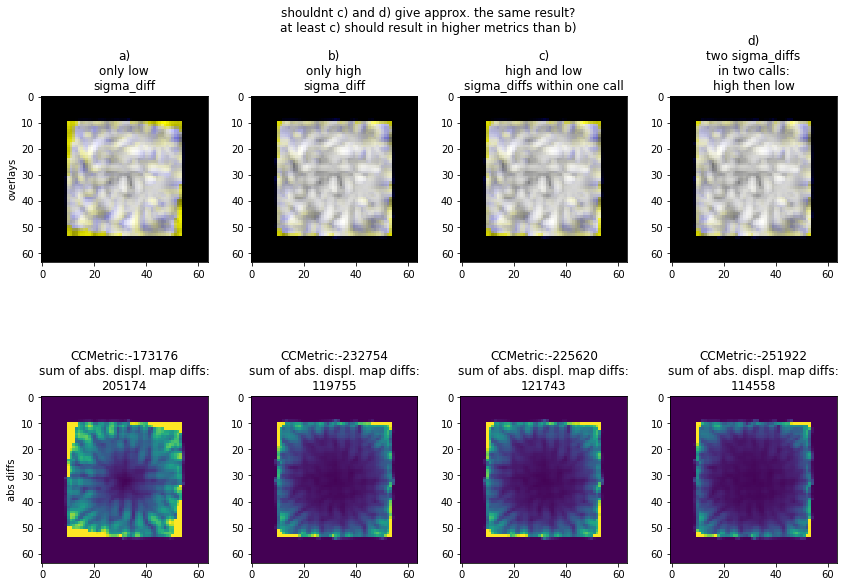

In [6]:
fig,axs = plt.subplots(2,4,figsize=(12,9))
# fig,axs = plt.subplots(3,1,figsize=(3,9))
fig.suptitle('shouldnt c) and d) give approx. the same result?\nat least c) should result in higher metrics than b)')

ims = [mt0,mt1,mt2,mt3]
ims = [mt0,mt1,mt2,mt3]
evs = [e0, e1, e2, e3 ]

titles = ['a)\nonly low\nsigma_diff','b)\nonly high\nsigma_diff','c)\nhigh and low\nsigma_diffs within one call','d)\ntwo sigma_diffs\nin two calls:\nhigh then low']

for i in range(len(ims)):
    axs[0][i].imshow(np.moveaxis(np.abs([f,f,ims[i]]).max(-3),0,-1),vmin=0,vmax=1)
    axs[0][i].set_title(titles[i])
#     axs[i].set_title('CCMetric:\n%06d\nsum of abs. displ. map diffs:\n%05d' %(evs[i][-1],mapdiffs[i]))
#     axs[0][i].axis('equal')
    axs[1][i].imshow(np.abs(ims[i]-f).mean(-3),vmin=0,vmax=0.2)
    axs[1][i].set_title('CCMetric:%06d\nsum of abs. displ. map diffs:\n%05d' %(evs[i][-1],mapdiffs[i]))
#     axs[i].axis('equal')

axs[0][0].set_ylabel('overlays')
axs[1][0].set_ylabel('abs diffs')
    
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


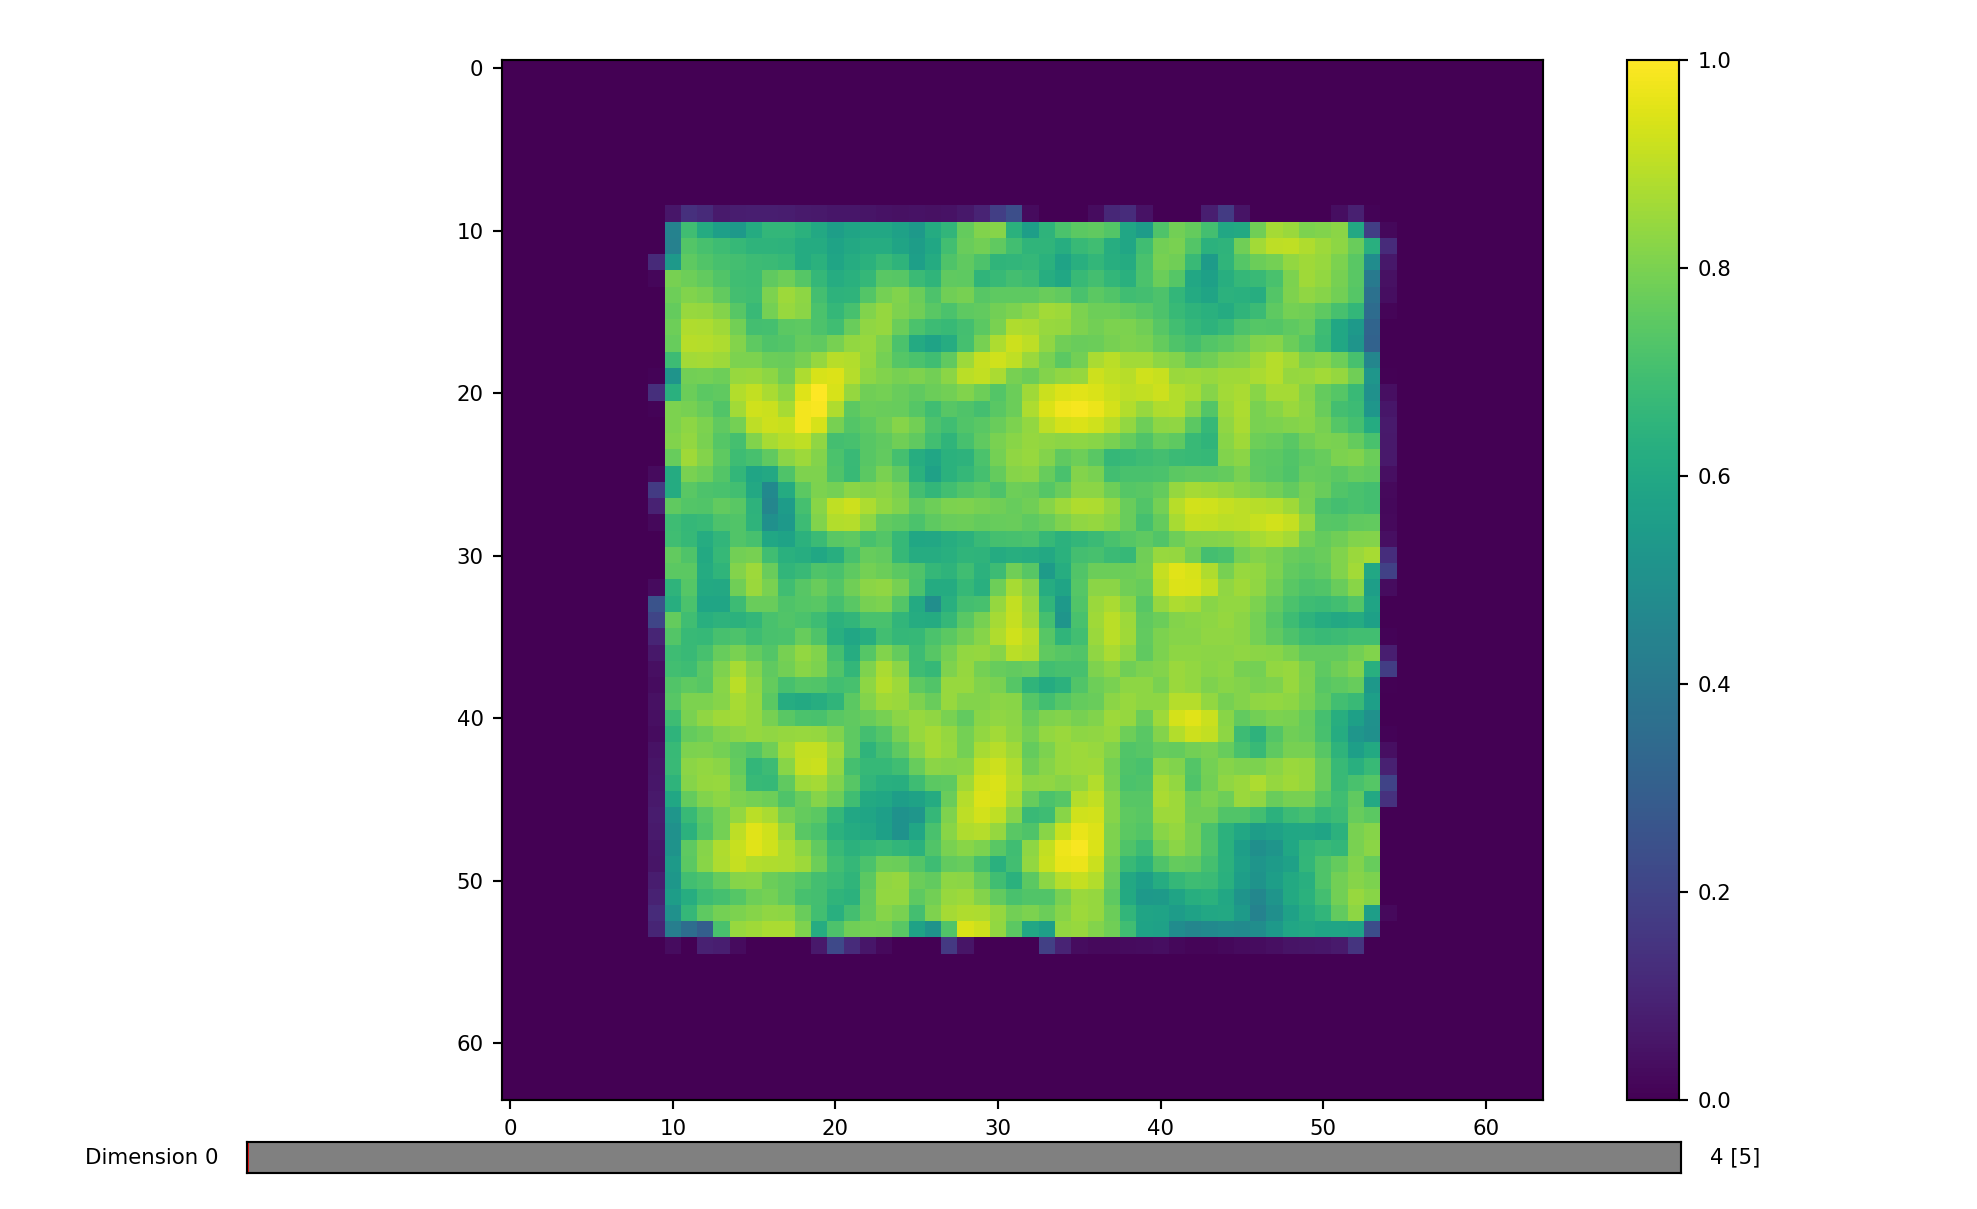

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7fe07a8e8710>)

In [265]:
# import tifffile
# %matplotlib notebook
# tifffile.imshow(np.array([f,mt0,mt1,mt2,mt3]).max(-3),photometric='zeroisblack')